# Predicting if a student will get admission or not

In [33]:
import pandas as pd
import numpy as np

In [34]:
admission = pd.read_csv( "admission.csv" )

In [35]:
admission.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [36]:
admission.columns = ["admit", "gre", "gpa", "ranking" ]

## Does the ranking of the college impact the admissions and how much

In [37]:
pd.crosstab( admission.admit, admission.ranking )

ranking,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


In [38]:
admit_by_rankings = pd.crosstab( admission.admit, admission.ranking ).apply( lambda x: x/x.sum(), axis = 0 )

In [39]:
admit_by_rankings

ranking,1,2,3,4
admit,,,,
0,0.459016,0.642384,0.768595,0.820896
1,0.540984,0.357616,0.231405,0.179104


In [40]:
admit_by_rankings = pd.DataFrame( admit_by_rankings.unstack() ).reset_index()

In [41]:
admit_by_rankings

,ranking,admit,0
0,1,0,0.459016
1,1,1,0.540984
2,2,0,0.642384
3,2,1,0.357616
4,3,0,0.768595
5,3,1,0.231405
6,4,0,0.820896
7,4,1,0.179104


In [42]:
admit_by_rankings.columns = ["ranking", "admit", "total" ]

In [43]:
import matplotlib as plt
import seaborn as sn
%matplotlib inline

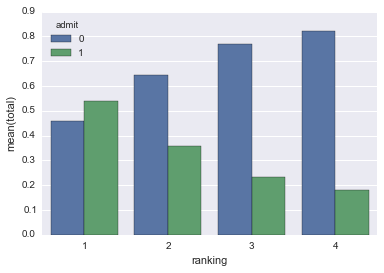

In [44]:
sn.barplot( admit_by_rankings.ranking, admit_by_rankings.total, hue = admit_by_rankings.admit )

## Is the mean GRE and GPA score different for student who got admitted and who did not?

In [45]:
gre_0 = admission[admission.admit == 0]["gre"]

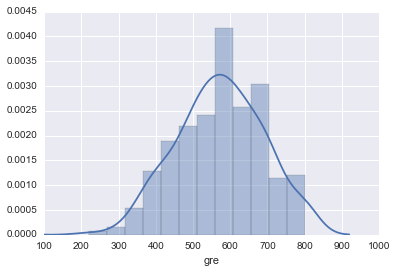

In [46]:
sn.distplot( gre_0 )

In [47]:
gre_1 = admission[admission.admit == 1]["gre"]

In [ ]:
sn.distplot( gre_1 )

In [ ]:
g = sn.FacetGrid(admission, col="admit", size = 10)
g.map(sn.distplot, "gre")

In [ ]:
g = sn.FacetGrid(admission, col="admit", size = 10)
g.map(sn.distplot, "gpa")

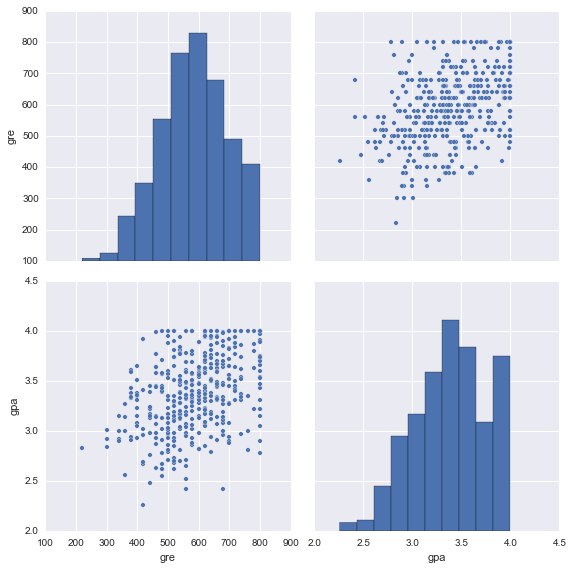

In [51]:
sn.pairplot( admission[["gre", "gpa"]], size = 4 )

In [ ]:
g = sn.FacetGrid(admission, row="ranking", size = 6)
g.map(sn.distplot, "gre")

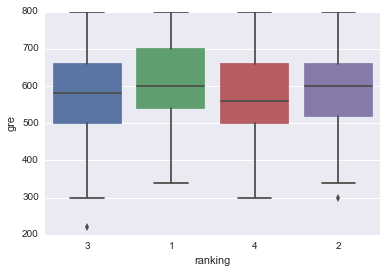

In [53]:
sn.boxplot( "ranking", "gre", data = admission )

## Building a Classification Model

### Convert the categorical variables into dummy variables

In [54]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [55]:
admission_new = create_dummies( admission, "ranking" )

In [56]:
admission_new.head()

,admit,gre,gpa,ranking_2,ranking_3,ranking_4
0,0,380,3.61,0,1,0
1,1,660,3.67,0,1,0
2,1,800,4.00,0,0,0
3,1,640,3.19,0,0,1
4,0,520,2.93,0,0,1


In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
logreg = LogisticRegression()

In [59]:
admission_new.columns

Index(['admit', 'gre', 'gpa', 'ranking_2', 'ranking_3', 'ranking_4'], dtype='object')

In [60]:
feature_cols = ['gre', 'gpa', 'ranking_2', 'ranking_3', 'ranking_4']

In [61]:
logreg.fit( admission_new[feature_cols], admission_new.admit )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [62]:
list( zip( feature_cols, logreg.coef_ ) )

[('gre',
  array([ 0.00181821,  0.24353836, -0.60583825, -1.1749243 , -1.37839861]))]

In [63]:
logreg.coef_

array([[ 0.00181821,  0.24353836, -0.60583825, -1.1749243 , -1.37839861]])

In [64]:
logreg.intercept_

array([-1.8727875])

In [65]:
admission_new["predicted_class"] = logreg.predict( admission_new[feature_cols] ) 

In [66]:
admission_new = pd.concat( [admission_new, pd.DataFrame( logreg.predict_proba( admission_new[feature_cols] ) )], axis = 1 )

In [67]:
admission_new.head()

,admit,gre,gpa,ranking_2,ranking_3,ranking_4,predicted_class,0,1
0,0,380,3.61,0,1,0,0,0.814212,0.185788
1,1,660,3.67,0,1,0,0,0.721900,0.278100
2,1,800,4.00,0,0,0,1,0.364488,0.635512
3,1,640,3.19,0,0,1,0,0.787621,0.212379
4,0,520,2.93,0,0,1,0,0.830918,0.169082


## Evaluating the model - Confusion Matrix

In [70]:
from sklearn import metrics

In [71]:
cm = metrics.confusion_matrix( admission_new.admit, admission_new.predicted_class )

In [72]:
cm

array([[259,  14],
       [103,  24]])

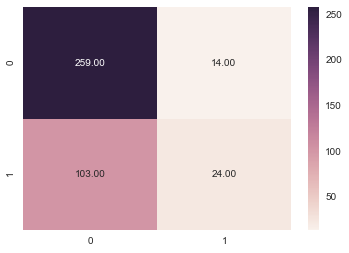

In [73]:
sn.heatmap(cm, annot=True,  fmt='.2f' );

## Accuracy Score

In [77]:
score = metrics.accuracy_score( admission_new.admit, admission_new.predicted_class )

In [79]:
score

0.70750000000000002

## ROC Curve

http://blog.yhathq.com/posts/roc-curves.html

In [80]:
auc_score = metrics.roc_auc_score( admission_new.admit, admission_new.predicted_class )

In [81]:
auc_score

0.56884716333535223

In [82]:
fpr, tpr, _ = metrics.roc_curve( admission_new.admit, admission_new.predicted_class )

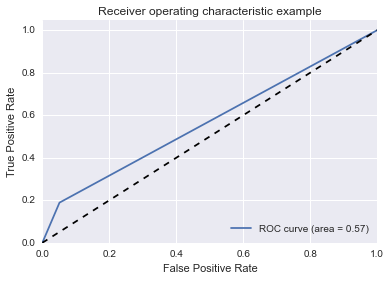

In [83]:
import matplotlib.pyplot as pyplt
pyplt.figure()
pyplt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
pyplt.plot([0, 1], [0, 1], 'k--')
pyplt.xlim([0.0, 1.0])
pyplt.ylim([0.0, 1.05])
pyplt.xlabel('False Positive Rate')
pyplt.ylabel('True Positive Rate')
pyplt.title('Receiver operating characteristic example')
pyplt.legend(loc="lower right")
pyplt.show()

In [91]:
print( metrics.classification_report( admission_new.admit, admission_new.predicted_class ) )

             precision    recall  f1-score   support

          0       0.72      0.95      0.82       273
          1       0.63      0.19      0.29       127

avg / total       0.69      0.71      0.65       400



## Cross validating the model

In [87]:
from sklearn.cross_validation import cross_val_score

In [88]:
logreg = LogisticRegression()
X = admission_new[feature_cols]
y = admission_new.admit
scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')

In [89]:
scores

array([ 0.82926829,  0.6097561 ,  0.73170732,  0.675     ,  0.725     ,
        0.675     ,  0.7       ,  0.66666667,  0.74358974,  0.66666667])

In [90]:
scores.mean()

0.70226547842401499